In [2]:
import os
import csv
import numpy as np
import pandas as pd
import multiprocessing
from time import perf_counter
from tqdm.auto import tqdm
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
    permutation_test_score, cross_validate
)
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from concurrent.futures import ProcessPoolExecutor, as_completed
import statsmodels.api as sm
from collections import Counter
import json
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [75]:
# CONFIG
labels_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/prematurity_labels_true_classes.csv"
base_path  = "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/embeddings/ABCD_embeddings/"
output_csv  = "/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/ABCD_prematurity_results_final.csv"
thresholds  = ["28-32","32-37"]

In [4]:
labels_df = pd.read_csv(labels_path, low_memory=False)
labels_df['src_subject_id'] = labels_df['src_subject_id'].str.replace("_","")

In [5]:
def load_embeddings(region):
    
    for file in os.listdir(base_path):
            if file.startswith(region) and file.endswith(".csv"):
                embedding_file = file
                break
            
    if embedding_file is None:
        raise FileNotFoundError(f"No embedding file found for region: {region}")

    print(f"Using embedding file: {embedding_file}")

    emb_path = os.path.join(base_path, embedding_file)
    emb_df = pd.read_csv(emb_path)
    emb_df['ID_clean'] = (
        emb_df['ID'].astype(str)
        .str.replace(r"^sub-", "", regex=True)
        .str.replace("_", "", regex=False)
    )
    return emb_df
    

In [6]:
def define_sex_class_mapping(sex_series):


    unique_sex = sorted(sex_series.unique())

    print("unique sites :", unique_sex)

    mapping = {1.0: 0, 2.0:1, 3.0 : 1}
    
    def encoder_fn(site):
        return mapping[site]
    
    return mapping, encoder_fn

def define_scan_age_mapping(scan_ages_series): 


    unique_scan_ages = sorted(scan_ages_series.unique())



    scaler = StandardScaler()
    scan_ages =np.array(scan_ages_series).reshape(-1 ,1)
    scaler.fit(scan_ages)
    print("unique_scan_ages :",unique_scan_ages)

    def encoder_fn(scan_age):
        return scaler.transform(np.array([[scan_age]])).item()

    
    return scaler, encoder_fn

In [7]:
def set_confound_df(label_counfounds_path = "/neurospin/dico/rmenasria/Runs/03_main/Input/ABCD/all_labels_clean_abcd_new_classes.csv"):
    
    counfounds_df = pd.read_csv(label_counfounds_path)
    counfounds_df = pd.get_dummies(counfounds_df,columns = ['site_id_l'],prefix='',prefix_sep='',drop_first=True)

    mapping, encode_site = define_sex_class_mapping(counfounds_df['demo_sex_v2'])
    counfounds_df['sex'] = counfounds_df['demo_sex_v2'].apply(encode_site)
    counfounds_df.drop(columns=['demo_sex_v2'],inplace=True)


    counfounds_df["interview_age"].fillna(115,inplace =True)

    scaler, encode_scan_age = define_scan_age_mapping(counfounds_df["interview_age"])

    counfounds_df['scan_age']= counfounds_df['interview_age'].apply(encode_scan_age)


    # Filter to keep only necessary columns
    columns_to_keep = ['scan_age','sex','src_subject_id_clean'] + [col for col in counfounds_df.columns if col.startswith('site')]
    counfounds_df = counfounds_df[columns_to_keep]

    print("counfounds_df columns :",counfounds_df.columns) 

    return counfounds_df


set_confound_df()


/tmp/ipykernel_1241051/2785468256.py:3: DtypeWarning: Columns (307,338,352,385,397,405,436,443) have mixed types. Specify dtype option on import or set low_memory=False.
  counfounds_df = pd.read_csv(label_counfounds_path)
/tmp/ipykernel_1241051/2785468256.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  counfounds_df["interview_age"].fillna(115,inplace =True)


unique sites : [1.0, 2.0, 3.0]
unique_scan_ages : [107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0]
counfounds_df columns : Index(['scan_age', 'sex', 'src_subject_id_clean', 'site02', 'site03', 'site04',
       'site05', 'site06', 'site07', 'site08', 'site09', 'site10', 'site11',
       'site12', 'site13', 'site14', 'site15', 'site16', 'site17', 'site18',
       'site19', 'site20', 'site21', 'site22'],
      dtype='object')


,scan_age,sex,src_subject_id_clean,site02,site03,site04,site05,site06,site07,site08,...,site13,site14,site15,site16,site17,site18,site19,site20,site21,site22
0,1.608618,1,NDARINV003RTV85,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.939494,0,NDARINV007W6H7B,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,-0.934053,0,NDARINV00BD7VDC,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,0.671845,0,NDARINV00HEV6HB,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-1.201702,0,NDARINV00J52GPG,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980,-1.201702,1,NDARINVZZLZCKAY,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
9981,-0.800228,1,NDARINVZZPKBDAC,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9982,0.270370,1,NDARINVZZZ2ALR6,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
9983,-1.469352,1,NDARINVZZZNB0XC,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
def _is_categorical(series, max_unique_for_cat=10):
    """if dtype is object or has few unique values, treat as categorical."""
    if series.dtype == object:
        return True
    if pd.api.types.is_integer_dtype(series) and series.nunique() <= max_unique_for_cat:
        return True
    return False

def _bin_continuous_for_strat(series, n_bins):
    """Returns a series of categories in quantiles; if qcut fails, falls back to cut."""
    try:
        b = pd.qcut(series, q=n_bins, duplicates='drop')
    except Exception:
        b = pd.cut(series, bins=n_bins, duplicates='drop')
    # transformer en string simple
    b = b.astype(str)
    # remplacer 'nan' par 'missing' si des NA
    b = b.fillna('missing')
    return b

In [100]:
def prepare_cv_data(
    embeddings_df,
    labels_df,
    confounds_df,
    id_emb_col='ID_clean',
    id_label_col='src_subject_id',
    id_conf_col='src_subject_id_clean',
    confounds_for_strat=[],
    confounds_for_resid=None,
    threshold="28-32",
    dim_regex=r'^dim',
    n_splits=5,
    init_n_bins=5,
    max_unique_for_cat=10,
):
    """
    Prepares and merges everything for cross-validation, returns:
      merged_df          : dataframe (aligned) containing dims, labels, confounds
      X_all              : numpy array of dims
      y_all              : numpy array of binary labels
      ids_all            : array of ids (src_subject_id)
      stratify_labels    : array of combined labels (to pass to StratifiedKFold.split(..., stratify_labels))
      confounds_resid_df : dataframe of encoded confounds (for residualization)
    
    Important parameters:
      confounds_for_strat  : list of columns to use for stratification (can include numeric columns)
      confounds_for_resid  : list of columns to use for residualization (must match those in confounds_df)
      onehot_site          : if True, one-hot encode the site column (drop_first=True) in confounds_resid_df
    """
    # Copy all three datasets
    emb = embeddings_df.copy()
    lab = labels_df.copy()
    cf = confounds_df.copy()

    # make ids comparable
    emb[id_emb_col] = emb[id_emb_col].astype(str)
    lab[id_label_col] = lab[id_label_col].astype(str)
    cf[id_conf_col]  = cf[id_conf_col].astype(str)


    # Merge emb + prematurity labels + confounds
    merged = emb.merge(lab, left_on=id_emb_col, right_on=id_label_col, how='inner')
    df = merged.merge(cf, left_on=id_emb_col, right_on=id_conf_col, how='inner', suffixes=('','_cf'))

    # set y
    df = df[df['prem_class'].isin([threshold, ">=37"])].copy()
    df['y'] = (df['prem_class'] == threshold).astype(int)
    
    # prepare X, y, ids
    X_all_df = df.filter(regex=dim_regex)
    X_all = X_all_df.values
    y_all = df['y'].values.astype(int)
    ids_all = df[id_label_col].astype(str).values

    # -confounds for resid
    if confounds_for_resid is None:
        confounds_for_resid = confounds_df.columns.tolist()
        confounds_for_resid.remove(id_conf_col)

    confounds_resid_df = confounds_df
    confounds_for_strat = confounds_for_resid.copy()


    # building the stratification labels
    if confounds_for_strat is None or len(confounds_for_strat) == 0:
        stratify_labels = y_all.astype(str)

    else:
        # columns copy from merged df
        strat_df = df[[id_label_col] + confounds_for_strat].copy()
        strat_df.set_index(id_label_col, inplace=True)
        # define the number of bins for continuous vars
        n_bins = init_n_bins
        while True:
            strat_cat_parts = []
            for c in confounds_for_strat:
                s = strat_df[c]
                if _is_categorical(s, max_unique_for_cat=max_unique_for_cat):
                    # str
                    part = s.astype(str).fillna('missing')
                else:
                    # continuous to bin
                    part = _bin_continuous_for_strat(s.fillna(s.median()), n_bins)
                strat_cat_parts.append(part.astype(str))
            # concatenate all parts with '|'
            strat_comb = strat_cat_parts[0].astype(str)
            for p in strat_cat_parts[1:]:
                strat_comb = strat_comb + '|' + p.astype(str)
            # add the label at the beginning to also strat on prematurity
            strat_comb = df['y'].astype(str).values + '||' + strat_comb.values

            # count min occurrences of any strata
            counts = pd.Series(strat_comb).value_counts()
            min_count = counts.min()
            if min_count >= n_splits:
                stratify_labels = strat_comb
                break
            else:
                # reduce n_bins and retry
                if n_bins > 2:
                    n_bins = max(2, n_bins - 1)
                    # print debug info
                    print(f"[prepare_cv_data] strata trop rares (min={min_count}), réduction bins -> {n_bins}")
                    continue
                else:
                    # if nothing works, fallback to y only
                    print("[prepare_cv_data] impossible d'obtenir strata valides, fallback à stratification sur y seulement.")
                    stratify_labels = df['y'].astype(str).values
                    break

    # final return
    return {
        'df_complete': df,                    # contains dims, labels, and confounds 
        'X_all_df': X_all_df,                   # DataFrame of dims
        'X_all': X_all,                         # numpy array dims
        'y_all': y_all,
        'ids_all': ids_all,
        'stratify_labels': np.array(stratify_labels, dtype=str),
        'confounds_resid_df': confounds_resid_df # DataFrame of confounds for resid
    }

In [101]:
def residualize_in_folds_from_prep(
    prep,
    confounds_list=None,
    id_label_col='src_subject_id',   # column id in prep['df_complete']
    id_emb_col='ID_clean',           # column id in the embeddings (prep['df_complete'])
    dim_regex=r'^dim',
    n_splits=5,
    random_state=42,
    use_statsmodels=True
):
    """
    Input:
    - prep: dict returned by prepare_cv_data(...)
    - confounds_list: list of column names (in prep['df_complete']) to use as covariates.
                        If None, it will be inferred from prep['confounds_resid_df']
                        (all columns except the ID column).
    - id_label_col / id_emb_col: column names of subject IDs in prep['df_complete'] (strings).
    - dim_regex: regex pattern used to select embedding columns.
    - n_splits: number of outer folds (must match the value used to build stratify_labels).
    - use_statsmodels: if True, perform OLS residualization dimension-by-dimension using statsmodels (slower).

    Output:
    - folds_residualized: list of dicts (one per outer fold), each containing:
        {
            'X_train_resid': np.array of shape (n_train, n_dims),
            'X_test_resid' : np.array of shape (n_test, n_dims),
            'y_train': np.array of shape (n_train,),
            'y_test' : np.array of shape (n_test,),
            'train_ids': list of subject IDs for training,
            'test_ids' : list of subject IDs for testing,
        }
    """

    # extraire infos from prep
    merged_df = prep['df_complete']            # df contains dims, y, confounds
    X_all = prep['X_all']
    y_all = prep['y_all']
    ids_all = prep['ids_all']
    stratify_labels = prep['stratify_labels']
    confounds_df = prep['confounds_resid_df']  #  just in case

    # get confound list if not provided
    if confounds_list is None:
        candidate = list(confounds_df.columns)
        # exclude id col
        candidate = [c for c in candidate if not any(tok in c.lower() for tok in ('src', 'id'))]
        confounds_list = candidate

    print(f"[residualize_in_folds_from_prep] using confounds: {confounds_list}")

    # sanity check : confounds exist in merged_df
    missing = [c for c in confounds_list if c not in merged_df.columns]
    if len(missing) > 0:
        raise ValueError(f"Confounds {missing} not found in merged_df columns. Adjust confounds_list or check prep.")

    # get embeddings columns
    X_df = merged_df.filter(regex=dim_regex)
    dim_cols = X_df.columns.tolist()
    n_dims = len(dim_cols)

    # build outer CV using stratify_labels fournis by prep
    outer = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    folds_residualized = []

    for fold_i, (train_idx, test_idx) in enumerate(outer.split(X_all, stratify_labels)):
        # ids corresponding to train/test idx
        train_ids = ids_all[train_idx]
        test_ids  = ids_all[test_idx]

        # sélectionner lignes correspondantes dans merged_df via id_emb_col
        # merged_df may contain ids as strings; ensure consistent dtype
        merged_df[id_emb_col] = merged_df[id_emb_col].astype(str)
        train_mask = merged_df[id_emb_col].isin([str(x) for x in train_ids])
        test_mask  = merged_df[id_emb_col].isin([str(x) for x in test_ids])

        X_train_emb_df = merged_df.loc[train_mask, dim_cols].astype(float)
        X_test_emb_df  = merged_df.loc[test_mask,  dim_cols].astype(float)
        conf_train_df  = merged_df.loc[train_mask, confounds_list].astype(float)
        conf_test_df   = merged_df.loc[test_mask,  confounds_list].astype(float)

        # checks (si certains ids n'existent pas dans merged_df ils sont automatiquement exclus)
        if X_train_emb_df.shape[0] == 0:
            raise ValueError(f"Fold {fold_i}: no train samples after matching ids.")
        if X_test_emb_df.shape[0] == 0:
            raise ValueError(f"Fold {fold_i}: no test samples after matching ids.")

        # perform residualization
        if use_statsmodels:
            # slow: OLS per-dimension
            # add constant
            X_conf_train = sm.add_constant(conf_train_df, has_constant='add')
            X_conf_test  = sm.add_constant(conf_test_df, has_constant='add')

            resid_train_df = pd.DataFrame(index=X_train_emb_df.index, columns=dim_cols, dtype=float)
            resid_test_df  = pd.DataFrame(index=X_test_emb_df.index,  columns=dim_cols, dtype=float) # je crois que les deux sont équivalents

            for col in dim_cols:
                y_tr_col = X_train_emb_df[col]
                ols = sm.OLS(y_tr_col, X_conf_train).fit()
                pred_tr = ols.predict(X_conf_train)
                pred_te = ols.predict(X_conf_test)
                resid_train_df[col] = y_tr_col - pred_tr
                resid_test_df[col]  = X_test_emb_df[col] - pred_te

        else:
            # fast: sklearn LinearRegression multi-output
            lr = LinearRegression()
            lr.fit(conf_train_df.values, X_train_emb_df.values)  # multi-output fit
            pred_train = lr.predict(conf_train_df.values)
            pred_test  = lr.predict(conf_test_df.values)

            resid_train_df = pd.DataFrame(pred_train, index=X_train_emb_df.index, columns=dim_cols)
            resid_test_df  = pd.DataFrame(pred_test,  index=X_test_emb_df.index,  columns=dim_cols)
            resid_train_df = X_train_emb_df.values - resid_train_df.values
            resid_test_df  = X_test_emb_df.values  - resid_test_df.values
            # wrap back to DataFrame with proper index/cols
            resid_train_df = pd.DataFrame(resid_train_df, index=X_train_emb_df.index, columns=dim_cols)
            resid_test_df  = pd.DataFrame(resid_test_df,  index=X_test_emb_df.index,  columns=dim_cols)

        # collect y aligned with the rows we will return
        # y_all is aligned with ids_all; train_idx/test_idx correspond to ids_all positions
        # but some ids could have been dropped if they were missing in merged_df; we must pick y by id.
        id_to_y = dict(zip(ids_all.astype(str), y_all.astype(int)))
        train_ids_present = merged_df.loc[train_mask, id_emb_col].astype(str).tolist()
        test_ids_present  = merged_df.loc[test_mask, id_emb_col].astype(str).tolist()

        

        y_train = np.array([id_to_y[i] for i in train_ids_present], dtype=int)
        y_test  = np.array([id_to_y[i] for i in test_ids_present], dtype=int)



        folds_residualized.append({
            'X_train_resid': resid_train_df.values,
            'X_test_resid' : resid_test_df.values,
            'y_train': y_train,
            'y_test' : y_test,
            'train_ids': train_ids_present,
            'test_ids' : test_ids_present
        })

    # Still add the entire data residualized for further analysis
    
    # This is not fold-specific, just for reference
    full_conf_df = merged_df[confounds_list].astype(float)
    lr_full = LinearRegression()
    lr_full.fit(full_conf_df.values, X_df.values)
    pred_full = lr_full.predict(full_conf_df.values)
    resid_full = X_df.values - pred_full
    merged_df_resid = merged_df.copy()
    merged_df_resid[dim_cols] = resid_full
    folds_residualized.append({
        'X_all_resid': merged_df_resid.filter(regex=dim_regex).values,
        'y_all': y_all,
        'ids_all': ids_all
    })


    return folds_residualized


In [102]:
def _mode_params(list_of_param_dicts):
    """Return the modal value for each hyperparameter across folds."""
    keys = set().union(*[set(d.keys()) for d in list_of_param_dicts])
    out = {}
    for k in keys:
        vals = [d[k] for d in list_of_param_dicts if k in d]
        # make values hashable for Counter (tuples for iterable non-strings)
        vals_keyed = [tuple(v) if hasattr(v, '__iter__') and not isinstance(v, str) else v for v in vals]
        out[k] = Counter(vals_keyed).most_common(1)[0][0]
    return out

def classify_with_resid(
    prep,
    folds_residualized,
    n_jobs=-1,
    n_permutations=11200,
    perm_seed=0,
    alpha=0.05,
    choose_param_strategy='mode'   # 'mode' or 'grid_full'
):
    """
    Classification pipeline that:
      - reuses the outer folds (train_ids/test_ids) produced by residualize_in_folds_from_prep,
      - runs nested GridSearchCV on each outer-train via sklearn.cross_validate (return_estimator=True),
      - picks a fixed hyper-parameter set (mode across folds, or grid search on full residualized data),
      - runs sklearn.permutation_test_score with the EXACT same outer splits (no gridsearch inside permutations),
      - refits a final pipeline on X_all_resid and returns coefficients in original feature space.

    Inputs:
      - prep: dict from prepare_cv_data (must contain 'stratify_labels' and 'ids_all' aligned with X_all).
      - folds_residualized: list produced by residualize_in_folds_from_prep. Must contain per-fold dicts
                           with 'train_ids'/'test_ids' and one final dict with keys 'X_all_resid','y_all','ids_all'.
      - choose_param_strategy: 'mode' (default) chooses most frequent best-params across folds;
                               'grid_full' runs a GridSearch on the full residualized dataset to choose final params.

    Returns: a dict with per-fold AUCs, mean/std, best params per fold, permutation results, final estimator and coefficients.
    """

    
    # find the full residualized entry (X_all_resid,y_all,ids_all)

    full_entry = None
    for e in folds_residualized[::-1]:
        if 'X_all_resid' in e:
            full_entry = e
            break
    if full_entry is None:
        raise ValueError("folds_residualized must contain a final entry with 'X_all_resid','y_all','ids_all'.")

    X_all_resid = full_entry['X_all_resid']
    y_all = np.array(full_entry['y_all'])
    ids_all = np.array(full_entry.get('ids_all', prep['ids_all']), dtype=str)

    # sanity: X_all_resid length must match prep stratify_labels length
    print(X_all_resid.shape[0])
        

   
    # build index mapping id to row-index in X_all_resid
    # and create 'splits' list out of the folds_residualized train/test ids

    id_to_index = {str(i): idx for idx, i in enumerate(ids_all)}

    splits = []
    for f in folds_residualized:
        if 'train_ids' not in f:
            continue
        # map ids -> indices (only keep ids present in id_to_index)
        train_idx = [id_to_index[i] for i in f['train_ids'] if i in id_to_index]
        test_idx  = [id_to_index[i] for i in f['test_ids']  if i in id_to_index]
        if len(train_idx) == 0 or len(test_idx) == 0:
            raise RuntimeError("One fold has no indices after mapping ids to indices. Check alignment between folds_residualized and full_entry ids.")
        splits.append((np.array(train_idx, dtype=int), np.array(test_idx, dtype=int)))

    n_outer_folds = len(splits)
    if n_outer_folds == 0:
        raise RuntimeError("No outer folds found in folds_residualized.")

    
    # nested GridSearch with cross_val using our explicit 'splits'
    # runs GridSearchCV (inner CV) as the estimator inside cross_validate.


    # explicit hyperparameter grid (pipeline keys)
    param_grid = {
        'clf__C': [10**k for k in range(-3, 4)],         
        #'clf__l1_ratio': np.linspace(0.0, 1.0, 11)   
    }
    inner_cv = 5

    base_clf_l2 = LogisticRegression(
    solver='lbfgs', penalty='l2',
    max_iter=100, class_weight='balanced', random_state=0
)
    base_clf_svc = SVC(
        kernel='linear', probability=True,
        class_weight='balanced', random_state=0
    )

    # pipeline to be used inside GridSearchCV
    base_clf = LogisticRegression(
        solver='saga', penalty='elasticnet',
        max_iter=100, class_weight='balanced', random_state=0
    )
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', base_clf_l2)])

    # GridSearchCV will be executed inside each outer fold by cross_validate with the 'splits' built
    grid_estimator = GridSearchCV(pipe, param_grid, cv=inner_cv, scoring='roc_auc', refit=True, n_jobs=n_jobs)

    print("Starting nested cross-validation with residualized data...")
    # run cross_validate using our precomputed outer splits; return the trained GridSearchCV objects per fold
    cv_res = cross_validate(
        grid_estimator,
        X_all_resid, y_all,
        cv=splits,
        scoring='roc_auc',
        return_estimator=True,
        n_jobs=n_jobs
    )

    # test scores per outer fold
    outer_fold_aucs = np.asarray(cv_res['test_score'], dtype=float)
    auc_mean = float(np.mean(outer_fold_aucs))
    auc_std = float(np.std(outer_fold_aucs))

    # extract best_params_ per fold from the returned GridSearchCV estimators
    best_params_per_fold = [est.best_params_ for est in cv_res['estimator']]

    
    # pick fixed hyper-parameters (mode or grid_full)
    
    
    if choose_param_strategy == 'mode':
        fixed_param_vals = _mode_params(best_params_per_fold)  
    elif choose_param_strategy == 'grid_full':
        # run GridSearch on full residualized dataset to select final hyperparams
        grid_full = GridSearchCV(pipe, param_grid, cv=inner_cv, scoring='roc_auc', refit=True, n_jobs=n_jobs)
        grid_full.fit(X_all_resid, y_all)
        fixed_param_vals = grid_full.best_params_
    else:
        raise ValueError("choose_param_strategy must be 'mode' or 'grid_full'")

    # explicit extraction (no kwargs magic)
    C_fixed = float(fixed_param_vals.get('clf__C', 1.0))
    #l1_ratio_fixed = float(fixed_param_vals.get('clf__l1_ratio', 0.0))

    # 
    # build fixed estimator (pipeline) with chosen params, to pass to permutation_test_score
    #  Important: permutation_test_score will refit this fixed estimator on each train/test permutation,
    #  but WILL NOT redo GridSearch.
    print("Fixed hyper-parameters chosen:", fixed_param_vals)
    
    clf_fixed = LogisticRegression(
        solver='lbfgs', penalty='l2',
        C=C_fixed,
        max_iter=100, class_weight='balanced', random_state=0
    )
    pipe_fixed = Pipeline([('scaler', StandardScaler()), ('clf', clf_fixed)])

    
    # run sklearn permutation_test_score using exactly the same outer splits
    

    # permutation_test_score accepts cv as the list of (train_idx,test_idx) tuples we built above
    score_obs, perm_scores, pvalue = permutation_test_score(
        pipe_fixed, X_all_resid, y_all,
        scoring='roc_auc', cv=splits,
        n_permutations=n_permutations, n_jobs=n_jobs, random_state=perm_seed
    )

    ci95 = np.percentile(perm_scores, 95)
    auc_threshold_at_alpha = np.percentile(perm_scores, 100.0 * (1.0 - alpha))

    
    # refit final estimator on whole residualized data and back-transform coefficients to original scale
    

    final_estimator = None
    final_coef_original = None
    final_intercept_original = None
    try:
        pipe_fixed.fit(X_all_resid, y_all)
        final_estimator = pipe_fixed
        clf_trained = pipe_fixed.named_steps['clf']
        scaler_trained = pipe_fixed.named_steps['scaler']

        # coefficients in scaled (z) space
        w_z = clf_trained.coef_.copy()        # shape (1, n_features) for binary
        b_z = clf_trained.intercept_.copy()

        mu = scaler_trained.mean_
        sigma = scaler_trained.scale_
        # convert back to original feature scale:
        w_x = w_z / sigma[np.newaxis, :]
        b_x = b_z - (w_z / sigma[np.newaxis, :]).dot(mu)

        final_coef_original = w_x
        final_intercept_original = b_x
    except Exception as e:
        # keep best-effort: still return permutation results etc.
        print("Warning: final refit failed:", e)


    #results
    
    
    out = {
        'aucs_per_fold': list(outer_fold_aucs),
        'auc_mean': auc_mean,
        'auc_std': auc_std,
        'best_params_per_fold': best_params_per_fold,
        'fixed_C': C_fixed,
        'perm_scores': np.asarray(perm_scores),
        'perm_pvalue': float(pvalue),
        'ci95_null': float(ci95),
        'auc_threshold_at_alpha': float(auc_threshold_at_alpha),
        'final_estimator': final_estimator,
        'final_coef_original': final_coef_original,
        'final_intercept_original': final_intercept_original,
        'n_permutations': len(perm_scores)
    }

    return out


In [105]:
# test on a single region and threshold

embeddings_df = load_embeddings("SC-SPoC_left")
labels_df = labels_df
confounds_df = set_confound_df()
preps = prepare_cv_data(embeddings_df,labels_df,confounds_df)
folds_resids = residualize_in_folds_from_prep(preps)
results = classify_with_resid(preps, folds_resids, n_jobs=-1, n_permutations=1, choose_param_strategy='grid_full')

print(results)



Using embedding file: SC-SPoC_left_name07-57-18--53_embeddings.csv


/tmp/ipykernel_1241051/2785468256.py:3: DtypeWarning: Columns (307,338,352,385,397,405,436,443) have mixed types. Specify dtype option on import or set low_memory=False.
  counfounds_df = pd.read_csv(label_counfounds_path)
/tmp/ipykernel_1241051/2785468256.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  counfounds_df["interview_age"].fillna(115,inplace =True)


unique sites : [1.0, 2.0, 3.0]
unique_scan_ages : [107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0]
counfounds_df columns : Index(['scan_age', 'sex', 'src_subject_id_clean', 'site02', 'site03', 'site04',
       'site05', 'site06', 'site07', 'site08', 'site09', 'site10', 'site11',
       'site12', 'site13', 'site14', 'site15', 'site16', 'site17', 'site18',
       'site19', 'site20', 'site21', 'site22'],
      dtype='object')
[prepare_cv_data] strata trop rares (min=3), réduction bins -> 4
[prepare_cv_data] strata trop rares (min=4), réduction bins -> 3
[residualize_in_folds_from_prep] using confounds: ['scan_age', 'sex', 'site02', 'site03', 'site04', 'site05', 'site06', 'site07', 'site08', 'site09', 'site10', 'site11', 'site12', 'site13', 'site14', 'site15', 'site16', 'site17', 'site18', 'site19', 'site20', 'site21', 'site22']
8732
Starting nested c

/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation

Fixed hyper-parameters chosen: {'clf__C': 0.1}
{'aucs_per_fold': [0.5668480108806528, 0.542317331791016, 0.6353213350117375, 0.5049501582009321, 0.48198550675330865], 'auc_mean': 0.5462844685275294, 'auc_std': 0.053308616070462264, 'best_params_per_fold': [{'clf__C': 0.1}, {'clf__C': 0.1}, {'clf__C': 0.1}, {'clf__C': 1}, {'clf__C': 1}], 'fixed_C': 0.1, 'perm_scores': array([0.46535618]), 'perm_pvalue': 0.5, 'ci95_null': 0.4653561790313918, 'auc_threshold_at_alpha': 0.4653561790313918, 'final_estimator': Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    random_state=0))]), 'final_coef_original': array([[-0.01891862,  0.01493068,  0.01174403,  0.00254475,  0.02044717,
         0.00050328, -0.00868155, -0.03342376,  0.00912863, -0.00234979,
        -0.01652208,  0.00452955,  0.00527482, -0.00561787,  0.03280015,
        -0.00713222,  0.0240048 , -0.00136736, -0.00045

Fold 0: train=6985, test=1747
Fold 1: train=6985, test=1747
Fold 2: train=6986, test=1746
Fold 3: train=6986, test=1746
Fold 4: train=6986, test=1746


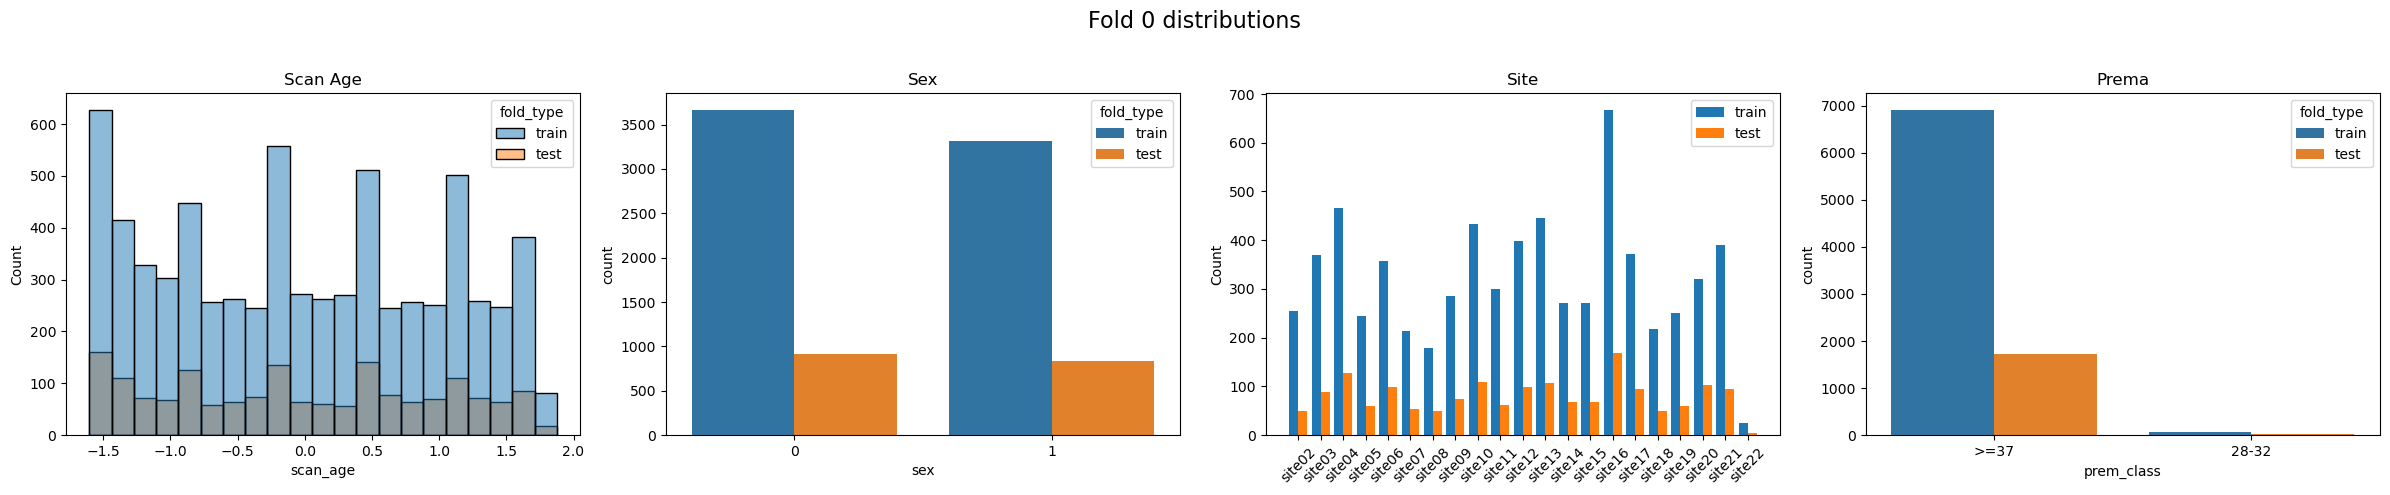

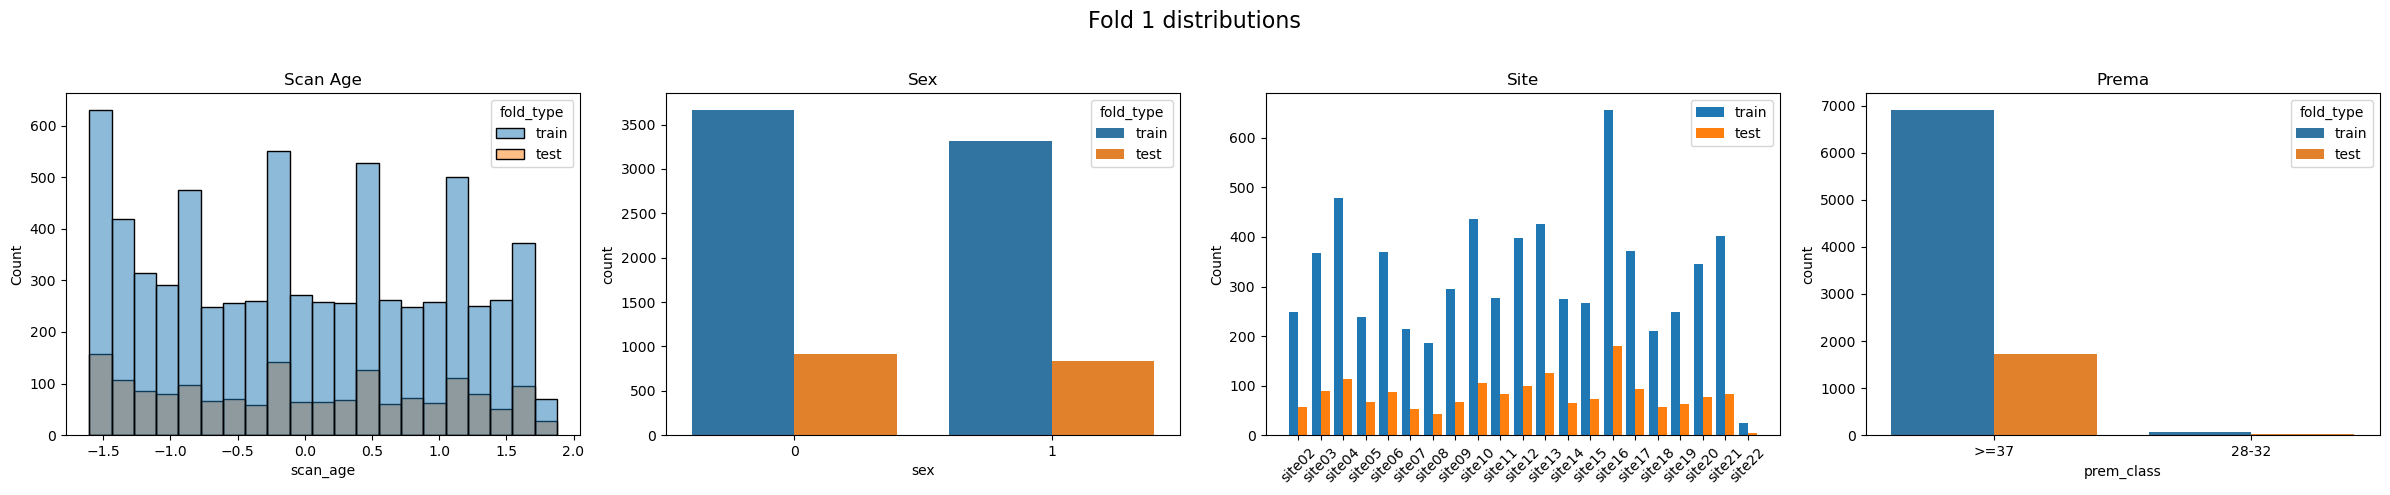

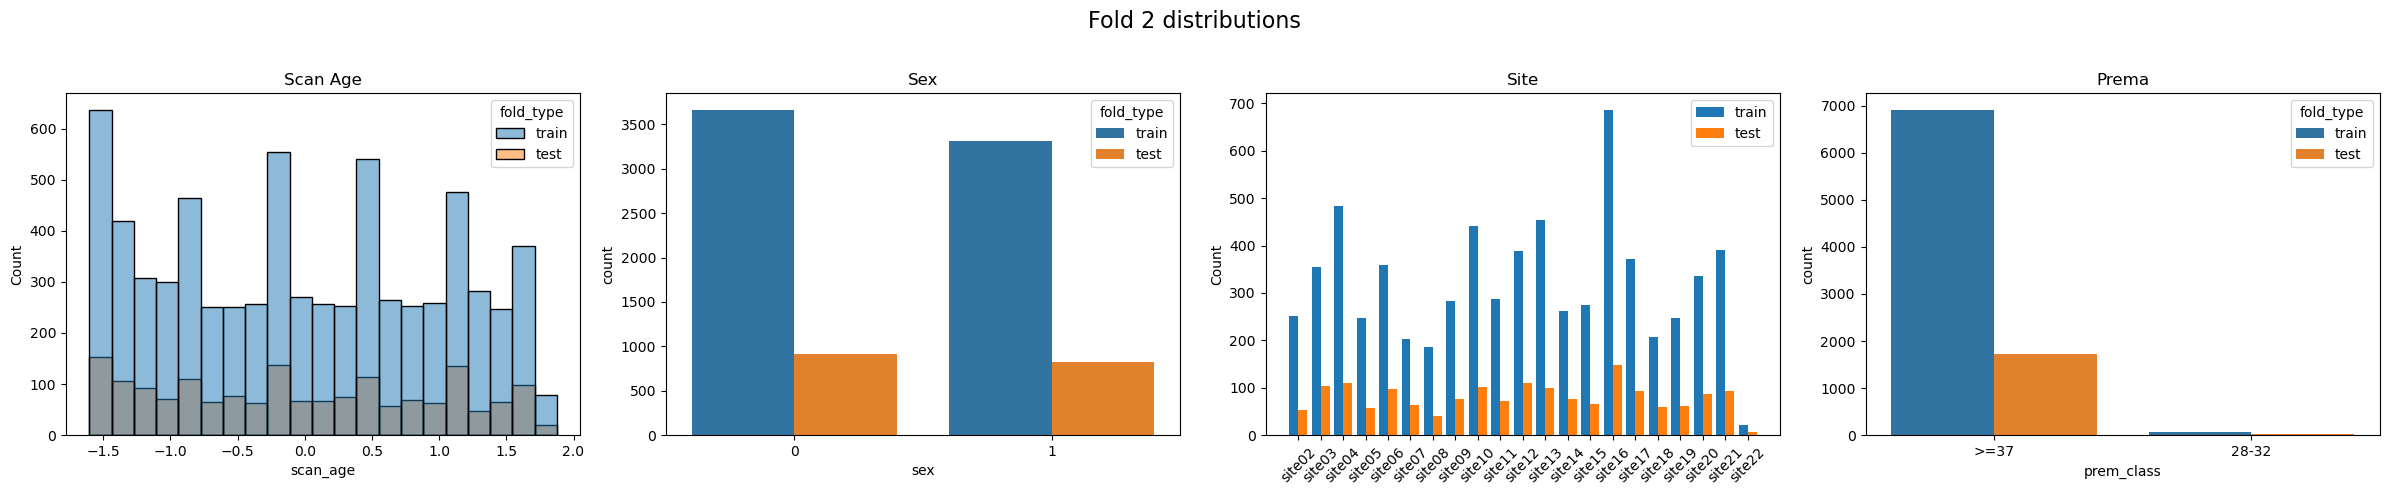

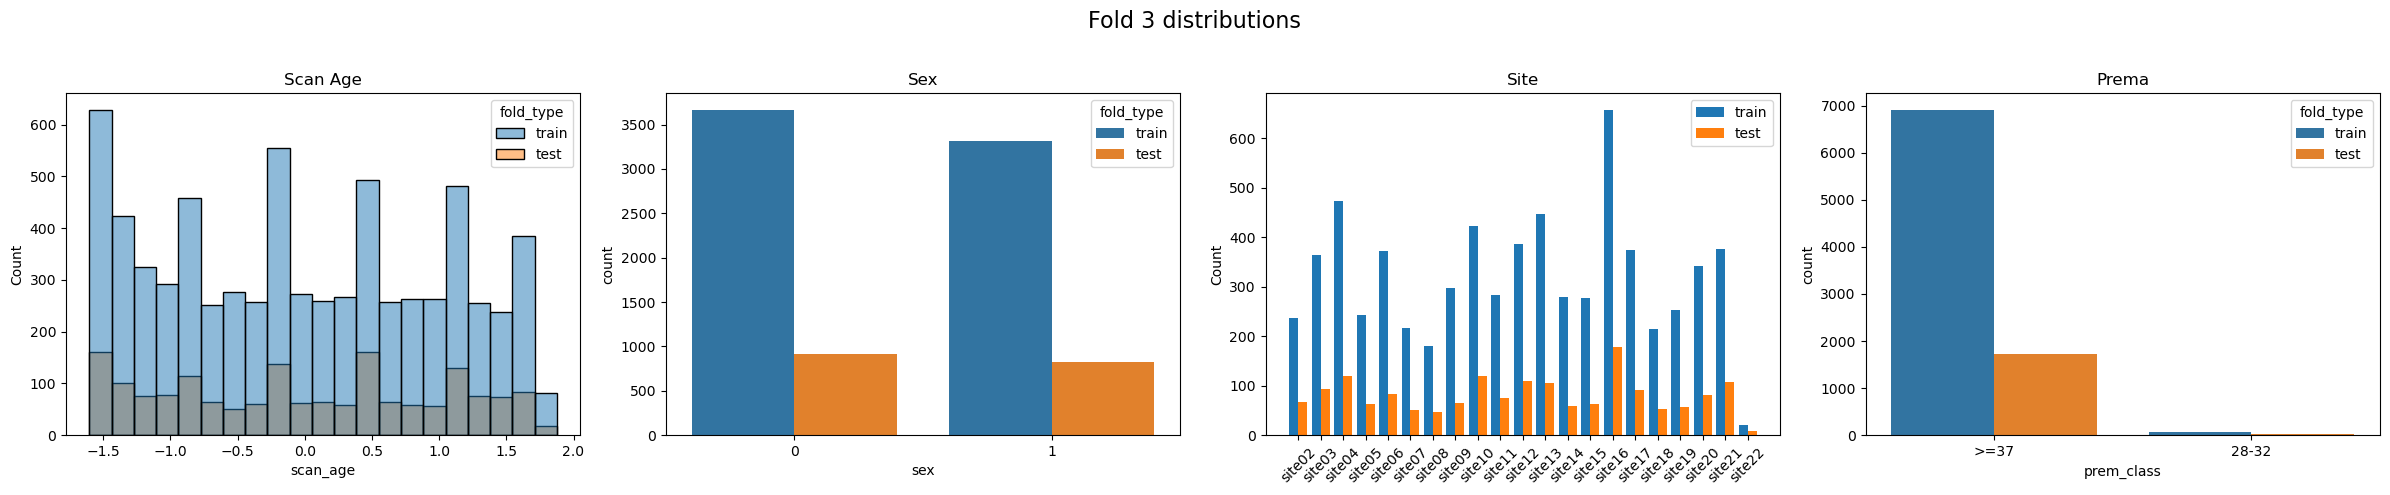

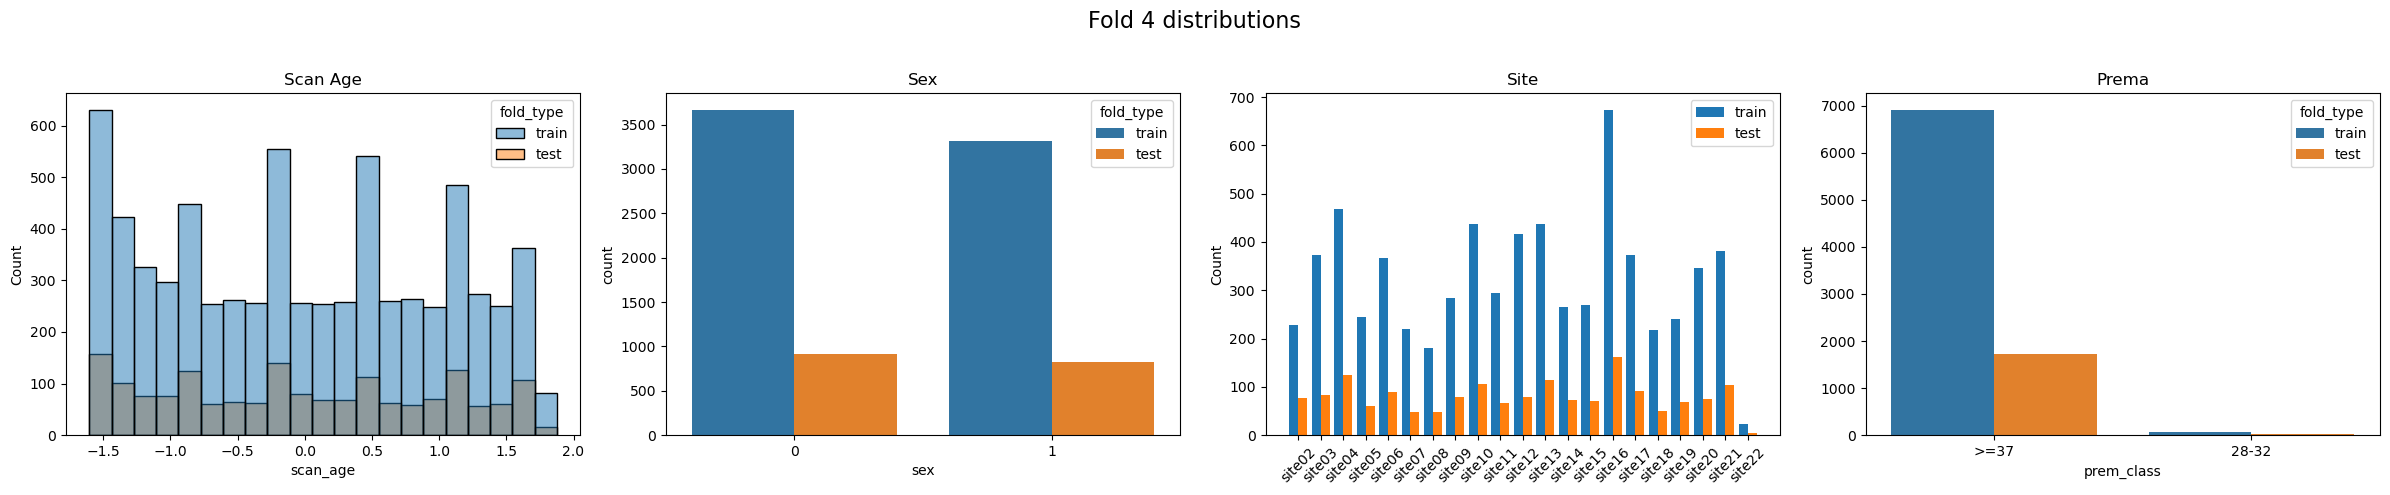

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_fold_distributions(folds_residualized, df_complete, id_label_col='subject_id'):
    """
    Plot distributions of scan_age, sex, site, and prema for each fold, 
    comparing train vs test sets.

    folds_residualized : list of dicts from residualize_in_folds_from_prep()
    df_complete : original dataframe containing scan_age, sex, site, prema, and IDs
    id_label_col : column name in df_complete that contains IDs
    
    """

    for i, fold in enumerate(folds_resids):
        if 'y_train' not in fold:
            continue
        print(f"Fold {i}: train={len(fold['train_ids'])}, test={len(fold['test_ids'])}")

    n_folds = len([f for f in folds_residualized if 'y_train' in f])

    for i, fold in enumerate(folds_residualized):
        if 'y_train' not in fold:
            continue

        train_ids = [str(x) for x in fold['train_ids']]
        test_ids  = [str(x) for x in fold['test_ids']]

        # Build a dataframe with fold_type
        df_train = df_complete[df_complete[id_label_col].astype(str).isin(train_ids)].copy()
        df_train['fold_type'] = 'train'

        df_test = df_complete[df_complete[id_label_col].astype(str).isin(test_ids)].copy()
        df_test['fold_type'] = 'test'

        df_fold = pd.concat([df_train, df_test])

        fig, axes = plt.subplots(1, 4, figsize=(24, 5))
        fig.suptitle(f"Fold {i} distributions", fontsize=16)

        # Scan age
        sns.histplot(data=df_fold, x='scan_age', hue='fold_type', kde=False, ax=axes[0])
        axes[0].set_title("Scan Age")

        # Sex
        sns.countplot(data=df_fold, x='sex', hue='fold_type', ax=axes[1])
        axes[1].set_title("Sex")

        # Site
        site_cols = [f'site{str(j).zfill(2)}' for j in range(2,23)]
        site_counts_train = df_fold[df_fold['fold_type']=='train'][site_cols].sum()
        site_counts_test  = df_fold[df_fold['fold_type']=='test'][site_cols].sum()
        x = np.arange(len(site_cols))
        axes[2].bar(x - 0.2, site_counts_train.values, width=0.4, label='train')
        axes[2].bar(x + 0.2, site_counts_test.values, width=0.4, label='test')
        axes[2].set_xticks(x)
        axes[2].set_xticklabels(site_cols, rotation=45)
        axes[2].set_ylabel("Count")
        axes[2].set_title("Site")
        axes[2].legend()

        # Prema
        sns.countplot(data=df_fold, x='prem_class', hue='fold_type', ax=axes[3])
        axes[3].set_title("Prema")

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()



plot_fold_distributions(folds_resids, preps['df_complete'], id_label_col='src_subject_id')


In [53]:
def get_region_list(json_file_path="/neurospin/dico/data/deep_folding/current/sulci_regions_champollion_V1.json"):
   

    with open(json_file_path, 'r') as f:
        data = json.load(f)["brain"]


    def extract_keys(d, sep='_'):
        keys = []
        for k, v in d.items():
            new_key = k
            keys.append(new_key)

        return keys
    
    # Remove all the "." in the keys
    region_list = extract_keys(data)
    region_list = [region.replace('.','') for region in region_list]

    return region_list

region_list = get_region_list()
print("region_list :",region_list)
print(len(region_list))

    

region_list : ['SC-sylv_left', 'SC-SPeC_left', 'SC-SPoC_left', 'SPeC_left', 'SPoC_left', 'SFint-FCMant_left', 'SFinf-BROCA-SPeCinf_left', 'STs_left', 'ScCal-SLi_left', 'FCMpost-SpC_left', 'STi-SOTlat_left', 'OCCIPITAL_left', 'FIP-FIPPoCinf_left', 'SFinter-SFsup_left', 'SFmedian-SFpoltr-SFsup_left', 'SOr_left', 'SOr-SOlf_left', 'FPO-SCu-ScCal_left', 'SsP-SPaint_left', 'STsbr_left', 'Lobule_parietal_sup_left', 'SFmarginal-SFinfant_left', 'FColl-SRh_left', 'STi-STs-STpol_left', 'FCLp-subsc-FCLa-INSULA_left', 'SFint-SR_left', 'SCall_left', 'SCall-SsP-SintraCing_left', 'SC-sylv_right', 'SC-SPeC_right', 'SC-SPoC_right', 'SPeC_right', 'SPoC_right', 'SFint-FCMant_right', 'SFinf-BROCA-SPeCinf_right', 'STs_right', 'ScCal-SLi_right', 'FCMpost-SpC_right', 'STi-SOTlat_right', 'OCCIPITAL_right', 'FIP-FIPPoCinf_right', 'SFinter-SFsup_right', 'SFmedian-SFpoltr-SFsup_right', 'SOr_right', 'SOr-SOlf_right', 'FPO-SCu-ScCal_right', 'SsP-SPaint_right', 'STsbr_right', 'Lobule_parietal_sup_right', 'SFmarginal

In [12]:
def process_combo(region, threshold, n_jobs=1, n_permutations=11200):
    """Process a single (region, threshold) combo."""
    start_time = perf_counter()

    # embeddings
    embeddings_df = load_embeddings(region)

    # confounds
    confounds_df = set_confound_df()

    # prepare CV data
    preps = prepare_cv_data(embeddings_df, labels_df, confounds_df, threshold=threshold)

    # residualization
    folds_resids = residualize_in_folds_from_prep(preps)

    # classification
    results = classify_with_resid(
        preps, folds_resids,
        n_jobs=n_jobs,
        n_permutations=n_permutations,
        choose_param_strategy='grid_full'
    )

    # retourner un dict compatible avec ton CSV
    duration_min = (perf_counter() - start_time) / 60.0
    out_dict = {
        'region': region,
        'threshold': threshold,
        'best_C': results['fixed_C'],
        'cv_auc_mean': results['auc_mean'],
        'cv_auc_std': results['auc_std'],
        'perm_pvalue': results['perm_pvalue'],
        'ci95_null': results['ci95_null'],
        'auc_threshold_at_alpha': results['auc_threshold_at_alpha'],
        'duration_min': duration_min
        'final_estimator': results['final_estimator']
        'final_coef_original': results['final_coef_original'],
        'final_intercept_original': results['final_intercept_original'],
        'perm_scores': results['perm_scores']
    }
    return out_dict


# --- Gestion checkpoint ---
if os.path.exists(output_csv):
    done_df = pd.read_csv(output_csv)
    done_set = set(zip(done_df['region'], done_df['threshold']))
else:
    done_set = set()

# Combinaisons à tester
combos = [(r, t) for r in region_list for t in thresholds]
pending_combos = [(r, t) for r, t in combos if (r, t) not in done_set]

print(f"Total combos: {len(combos)}, déjà faits: {len(done_set)}, à calculer: {len(pending_combos)}")

# Paramètres de parallélisation
n_jobs_outer = 3   # processus externes
n_jobs_inner = 28  # pour GridSearch / permutation interne

# Ouvre en append si fichier existe, sinon création + header
file_exists = os.path.exists(output_csv)
with open(output_csv, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=[
        'region', 'threshold', 'best_C',
        'cv_auc_mean', 'cv_auc_std', 'perm_pvalue',
        'ci95_null', 'auc_threshold_at_alpha', 'duration_min', 
        'final_estimator', 'final_coef_original', 'final_intercept_original', 'perm_scores'
    ])
    if not file_exists:
        writer.writeheader()

    with ProcessPoolExecutor(max_workers=n_jobs_outer) as exe:
        futures = {
            exe.submit(process_combo, r, t, n_jobs_inner, 11200): (r, t)
            for r, t in pending_combos
        }
        for future in tqdm(as_completed(futures), total=len(futures), desc="Blocs traités"):
            try:
                res = future.result()
                writer.writerow(res)
                f.flush()
            except Exception as e:
                r, t = futures[future]
                print(f"Erreur pour combo ({r},{t}): {e}")

print("Terminé : résultats checkpoint dans", output_csv)



Total combos: 116, déjà faits: 0, à calculer: 116
Début traitement : region=CINGULATE_right, seuil=28-32Début traitement : region=CINGULATE_left, seuil=32-37Début traitement : region=CINGULATE_left, seuil=28-32


Using embedding file: CINGULATE_left_name17-24-32--191_embeddings.csv

Blocs traités:   0%|          | 0/116 [00:00<?, ?it/s]

Using embedding file: CINGULATE_right_name17-24-32--237_embeddings.csvUsing embedding file: CINGULATE_left_name17-24-32--191_embeddings.csv


CINGULATE_left–28-32 → AUC 0.562
Best_score: 0.5720534660394
Début traitement : region=CINGULATE_right, seuil=32-37

Using embedding file: CINGULATE_right_name17-24-32--237_embeddings.csvCINGULATE_left–32-37 → AUC 0.543
Best_score: 0.5456837538735926
Début traitement : region=FCLp-subsc-FCLa-INSULA_left, seuil=28-32
Using embedding file: FCLp-subsc-FCLa-INSULA_left_name17-43-58--232_embeddings.csv
CINGULATE_right–28-32 → AUC 0.555
Best_score: 0.5693785134594741
Début traitement : region=FCLp-subsc-FCLa-INSULA_left, seuil=32-37
Using embedding file: FCLp-subsc-FCLa-INSULA_left_name17-43-58--232_embeddings.csv
FCLp-subsc-FCLa-INSULA_left–28-32 → AUC 0.716
Best_score: 0.7287711392623792
Début traitement : region=FCLp-subsc-FCLa-INSULA_right, seuil=28-32
Using embedding file: FCLp-subsc-FCLa-INSULA_right_name17-47-16--166_embeddings.csv
CINGULATE_rig

/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


FPO-SCu-ScCal_right–32-37 → AUC 0.595
Best_score: 0.5958167952529579
Début traitement : region=LARGE_CINGULATE_right, seuil=28-32
Using embedding file: LARGE_CINGULATE_right_name07-22-35--179_embeddings.csv


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


LARGE_CINGULATE_left–28-32 → AUC 0.591
Best_score: 0.5956406425963862
Début traitement : region=LARGE_CINGULATE_right, seuil=32-37
Using embedding file: LARGE_CINGULATE_right_name07-22-35--179_embeddings.csv
LARGE_CINGULATE_right–28-32 → AUC 0.586
Best_score: 0.5998094251312812
Début traitement : region=Lobule_parietal_sup_left, seuil=28-32
Using embedding file: Lobule_parietal_sup_left_name07-23-04--36_embeddings.csv
LARGE_CINGULATE_left–32-37 → AUC 0.565
Best_score: 0.565807622713278
Début traitement : region=Lobule_parietal_sup_left, seuil=32-37
Using embedding file: Lobule_parietal_sup_left_name07-23-04--36_embeddings.csv
LARGE_CINGULATE_right–32-37 → AUC 0.570
Best_score: 0.570839610485353
Début traitement : region=Lobule_parietal_sup_right, seuil=28-32
Using embedding file: Lobule_parietal_sup_right_name07-24-01--193_embeddings.csv
Lobule_parietal_sup_left–28-32 → AUC 0.538
Best_score: 0.552190398489008
Début traitement : region=Lobule_parietal_sup_right, seuil=32-37
Using embedd

/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SC-SPoC_right–28-32 → AUC 0.529
Best_score: 0.5424270735339294
Début traitement : region=SC-sylv_left, seuil=32-37
Using embedding file: SC-sylv_left_name07-58-00--111_embeddings.csv
SC-SPoC_right–32-37 → AUC 0.538
Best_score: 0.5397311051233912
Début traitement : region=SC-sylv_right, seuil=28-32
Using embedding file: SC-sylv_right_name06-17-02--84_embeddings.csv
SC-sylv_left–28-32 → AUC 0.537
Best_score: 0.5556174567055219
Début traitement : region=SC-sylv_right, seuil=32-37
Using embedding file: SC-sylv_right_name06-17-02--84_embeddings.csv
SC-sylv_left–32-37 → AUC 0.558
Best_score: 0.5598619074020487
Début traitement : region=SFinf-BROCA-SPeCinf_left, seuil=28-32
Using embedding file: SFinf-BROCA-SPeCinf_left_name08-00-45--128_embeddings.csv
SFinf-BROCA-SPeCinf_left–28-32 → AUC 0.650
Best_score: 0.6518203406580078
Début traitement : region=SFinf-BROCA-SPeCinf_left, seuil=32-37
Using embedding file: SFinf-BROCA-SPeCinf_left_name08-00-45--128_embeddings.csv
SC-sylv_right–28-32 → AUC 

/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SFint-SR_left–32-37 → AUC 0.545
Best_score: 0.5455656537277738
Début traitement : region=SFinter-SFsup_left, seuil=28-32
Using embedding file: SFinter-SFsup_left_name08-06-01--220_embeddings.csv
SFint-SR_right–28-32 → AUC 0.611
Best_score: 0.6112419965685056
Début traitement : region=SFinter-SFsup_left, seuil=32-37
Using embedding file: SFinter-SFsup_left_name08-06-01--220_embeddings.csv
SFinter-SFsup_left–28-32 → AUC 0.537
Best_score: 0.5504237647099903
Début traitement : region=SFinter-SFsup_right, seuil=28-32
Using embedding file: SFinter-SFsup_right_name08-08-42--126_embeddings.csv
SFinter-SFsup_left–32-37 → AUC 0.552
Best_score: 0.5549725842583226
Début traitement : region=SFinter-SFsup_right, seuil=32-37
Using embedding file: SFinter-SFsup_right_name08-08-42--126_embeddings.csv


/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SFint-SR_right–32-37 → AUC 0.559
Best_score: 0.5605150149003038
Début traitement : region=SFmarginal-SFinfant_left, seuil=28-32
Using embedding file: SFmarginal-SFinfant_left_name08-15-17--25_embeddings.csv
SFinter-SFsup_right–32-37 → AUC 0.553
Best_score: 0.5531710617496371
Début traitement : region=SFmarginal-SFinfant_left, seuil=32-37
Using embedding file: SFmarginal-SFinfant_left_name08-15-17--25_embeddings.csv
SFmarginal-SFinfant_left–28-32 → AUC 0.570
Best_score: 0.5878826286546538
Début traitement : region=SFmarginal-SFinfant_right, seuil=28-32
Using embedding file: SFmarginal-SFinfant_right_name08-17-15--135_embeddings.csv
SFinter-SFsup_right–28-32 → AUC 0.620
Best_score: 0.6204928209065721
Début traitement : region=SFmarginal-SFinfant_right, seuil=32-37
Using embedding file: SFmarginal-SFinfant_right_name08-17-15--135_embeddings.csv
SFmarginal-SFinfant_right–28-32 → AUC 0.632
Best_score: 0.6323534666883688
Début traitement : region=SFmedian-SFpoltr-SFsup_left, seuil=28-32
Usin

/neurospin/dico/rmenasria/Runs/03_main/Program/main_pixi/.pixi/envs/default/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


SOr-SOlf_left–32-37 → AUC 0.634
Best_score: 0.634523011358356
Début traitement : region=SOr_left, seuil=28-32
Using embedding file: SOr_left_name14-12-56--162_embeddings.csv
SOr-SOlf_right–28-32 → AUC 0.657
Best_score: 0.6626339906208909
Début traitement : region=SOr_left, seuil=32-37
Using embedding file: SOr_left_name14-12-56--162_embeddings.csv
SOr-SOlf_right–32-37 → AUC 0.638
Best_score: 0.638720285775013
Début traitement : region=SOr_right, seuil=28-32
Using embedding file: SOr_right_name14-12-56--58_embeddings.csv
SOr_left–28-32 → AUC 0.668
Best_score: 0.6772536560277931
Début traitement : region=SOr_right, seuil=32-37
Using embedding file: SOr_right_name14-12-56--58_embeddings.csv
SOr_left–32-37 → AUC 0.635
Best_score: 0.6350766854502108
Début traitement : region=SPeC_left, seuil=28-32
Using embedding file: SPeC_left_name08-24-23--109_embeddings.csv
SOr_right–28-32 → AUC 0.634
Best_score: 0.6547175412878092
Début traitement : region=SPeC_left, seuil=32-37
Using embedding file: S

In [9]:
# Charger le fichier CSV d'origine
df = pd.read_csv('/neurospin/dico/rmenasria/Runs/03_main/Output/csv/ABCD_prematurity_results_0708.csv')

# Remplacer les AUC_mean non significatifs (p_value >= 0.05) par 0
df.loc[df['perm_pvalue'] >= 0.005, 'cv_auc_mean'] = 0.0

# Pivot pour avoir une colonne AUC par tranche
df_pivot = df.pivot(index='region', columns='threshold', values='cv_auc_mean')

# Renommer les colonnes
df_pivot = df_pivot.rename(columns={
    '28-32': 'AUC_28_32',
    '32-37': 'AUC_37'
}).reset_index()

# Exporter le résultat
output_csv = '/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/prematurity_AUC_by_region_ABCD_0708_thresholded.csv'
df_pivot.to_csv(output_csv, index=False)
print(f"Fichier généré : {output_csv}")

Fichier généré : /neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/prematurity_AUC_by_region_ABCD_0708_thresholded.csv


In [10]:
df = pd.read_csv("/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/ABCD_prematurity_results.csv")

# Pivot pour avoir une colonne AUC par tranche
df_pivot = df.pivot(index='region', columns='threshold', values='cv_auc_mean')

# Renommer les colonnes pour clarifier
df_pivot = df_pivot.rename(columns={
    '<27': 'AUC_27',
    '27-32': 'AUC_27_32',
    '32-37': 'AUC_32_37'
}).reset_index()

# Sauvegarder le nouveau CSV
output_csv = '/neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/prematurity_AUC_by_region_ABCD_2406.csv'
df_pivot.to_csv(output_csv, index=False)
print(f"Fichier généré : {output_csv}")



Fichier généré : /neurospin/dico/rmenasria/Runs/03_main/Program/2025_rmenasria_prematurity/notebooks/racim/prematurity_AUC_by_region_ABCD_2406.csv
